# **Classification**

In this notebook, we fine-tune a [XLM-RoBERTa](https://huggingface.co/docs/transformers/model_doc/xlm-roberta#xlm-roberta) model for news genre classification: opinion, report, or satire. Afterwards, the model is evaluated using macro-precision, macro-recall, and macro-F1. Also, the confusion matrix will be plotted.

XML-RoBERTa is a multilingual masked language model trained over 2.5TB of filtered CommonCrawl data across 100 languages. The tokenizer does not need to know the language, because the tokens' ID includes that information, thus it can be used for classification without an additional setup.

In [1]:
pip install --upgrade matplotlib seaborn pandas scikit-learn torch transformers accelerate bitsandbytes nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 16.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.9 MB/s  0:00:01m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 14.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 14.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 17.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.1 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 10.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 20.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 12.5 MB/s  0:00:02 eta 0:00:01


In [2]:
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_en.csv -O articles_en.csv
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_fr.csv -O articles_fr.csv
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_de.csv -O articles_de.csv
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_es.csv -O articles_es.csv
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_pl.csv -O articles_pl.csv
!wget https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_ru.csv -O articles_ru.csv

--2026-01-20 19:24:25--  https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5596803 (5.3M) [text/plain]
Saving to: ‘articles_en.csv’

articles_en.csv     100%[===================>]   5.34M  10.4MB/s    in 0.5s    

2026-01-20 19:24:26 (10.4 MB/s) - ‘articles_en.csv’ saved [5596803/5596803]

--2026-01-20 19:24:26--  https://raw.githubusercontent.com/VladWero08/mt-pattern-preserve/refs/heads/main/data/articles_fr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiti

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

## **Model**

In [23]:
# mapping
class_names = ["opinion", "reporting", "satire"]
id2label = {0: "opinion", 1: "reporting", 2: "satire"}
label2id = {v: k for k, v in id2label.items()}
label2onehot = {
    "opinion": [1, 0, 0],
    "reporting": [0, 1, 0],
    "satire": [0, 0, 1],
  }

model_id = "FacebookAI/xlm-roberta-large"
device = "cuda" if torch.cuda.is_available() else "cpu"
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
# load model
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    problem_type="single_label_classification"
).to(device)
# update config
model.config.id2label = id2label
model.config.label2id = label2id

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
text = "This is a sports article. Manchester United won 3-0 last night against Real Madrid."
inputs = tokenizer(text, return_tensors="pt").to(model.device)

with torch.no_grad():
  logits = model(**inputs).logits
  prediction_id = logits.argmax().item()
  prediction_label = model.config.id2label[prediction_id]

print(f"{text} --- prediction --> {prediction_label}")

This is a sports article. Manchester United won 3-0 last night against Real Madrid. --- prediction --> reporting


## **Dataset**

In [6]:
articles    = pd.read_csv("articles_en.csv")
articles_fr = pd.read_csv("articles_fr.csv")
articles_de = pd.read_csv("articles_de.csv")
articles_es = pd.read_csv("articles_es.csv")
articles_pl = pd.read_csv("articles_pl.csv")
articles_ru = pd.read_csv("articles_ru.csv")

# list with all articles data frames
articles_all = [
  (articles, "en"),
  (articles_fr, "fr"),
  (articles_de, "de"),
  (articles_es, "es"),
  (articles_pl, "pl"),
  (articles_ru, "ru"),
]

In [7]:
class NewsGenreDataset(torch.utils.data.Dataset):
    def __init__(self, articles: list[str], labels: list[int]) -> None:
        articles, labels = self.oversample(articles, labels)
        
        self.encodings = tokenizer(
            articles,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def oversample(self, articles: list[str], labels: list[int]) -> tuple[list]:
        articles_os = []
        labels_os = []

        for article, genre_label in zip(articles, labels):
            articles_os.append(article)
            labels_os.append(genre_label)
        
            if id2label[genre_label] == "satire":
                for _ in range(3):
                    articles_os.append(article)
                    labels_os.append(genre_label)

        return articles_os, labels_os
    
    def __getitem__(self, idx: int) -> dict:
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
    
    def __len__(self) -> int:
        return len(self.labels)

In [8]:
dataset = NewsGenreDataset(
    [article for article in articles["full_articles"].values],
    [label2id[genre] for genre in articles["genre"].values],
)

In [9]:
# split the dataset into train and validation
train_idxs, validation_idxs = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.labels)
train_dataset = torch.utils.data.Subset(dataset, train_idxs)
validation_dataset = torch.utils.data.Subset(dataset, validation_idxs)

In [31]:
counts = {0: 0, 1: 0, 2: 0}
for label in dataset.labels:
    counts[label.item()] += 1

class_weights = torch.tensor([
    len(dataset.labels) / (3 * counts[0]),
    len(dataset.labels) / (3 * counts[1]),
    len(dataset.labels) / (3 * counts[2]),
])
class_weights = class_weights / class_weights.min()
class_weights = class_weights.to(model.device)
print(f"Class weights: {class_weights}")

Class weights: tensor([1.0000, 4.2316, 5.2895], device='cuda:0')


## **Training**

In [11]:
class ClassWeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        global class_weights
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Compute weighted loss - move weights to same device as model
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [12]:
training_args = TrainingArguments(
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=1e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
)

In [25]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    problem_type="single_label_classification"
).to(device)

trainer = ClassWeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=tokenizer, 
)
trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.068203
2,No log,0.912700
3,No log,0.819440
4,No log,0.759894
5,No log,0.661686


TrainOutput(global_step=145, training_loss=0.8066883481782058, metrics={'train_runtime': 65.0858, 'train_samples_per_second': 35.184, 'train_steps_per_second': 2.228, 'total_flos': 2134130032773120.0, 'train_loss': 0.8066883481782058, 'epoch': 5.0})

## **Evaluation**

In [26]:
# compute the prediction logits
val_predictions = trainer.predict(validation_dataset)
# compute the prediction classes 
val_predictions_labels = np.argmax(val_predictions.predictions, axis=1)
# extract the true labels from the validation dataset
val_true_labels = np.array([dataset[idx]["labels"] for idx in validation_dataset.indices])

In [27]:
# compute metrics
precision = precision_score(val_true_labels, val_predictions_labels, average="macro")
recall = recall_score(val_true_labels, val_predictions_labels, average="macro")
f1 = f1_score(val_true_labels, val_predictions_labels, average="macro")
cm = confusion_matrix(val_true_labels, val_predictions_labels)

print("Metrics - average = macro")
print("-------------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Metrics - average = macro
-------------------------
Precision: 0.7173
Recall: 0.7659
F1: 0.7277


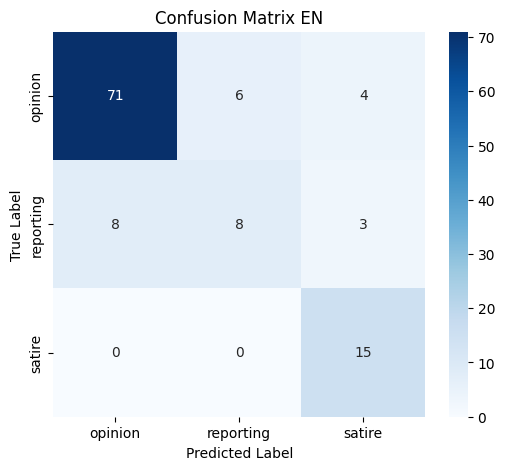

In [28]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix EN")
plt.show()

## **Full training and evaluation**

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.091307
2,No log,0.835399
3,No log,0.754836
4,No log,0.684506
5,No log,0.627140


Metrics - average = macro for EN
-------------------------
Precision: 0.7395
Recall: 0.7700
F1: 0.7407


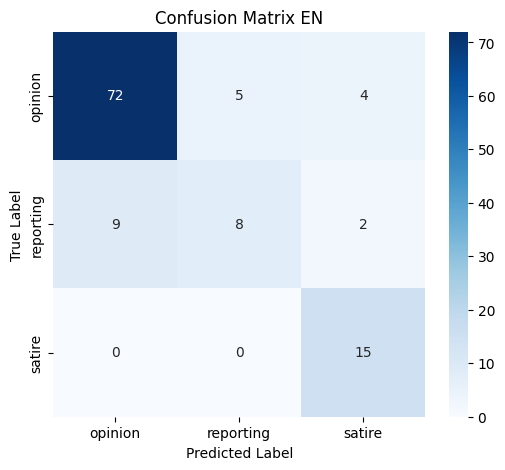

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.126158
2,No log,1.094102
3,No log,0.892021
4,No log,0.778889
5,No log,0.723196


Metrics - average = macro for FR
-------------------------
Precision: 0.8023
Recall: 0.7063
F1: 0.7172


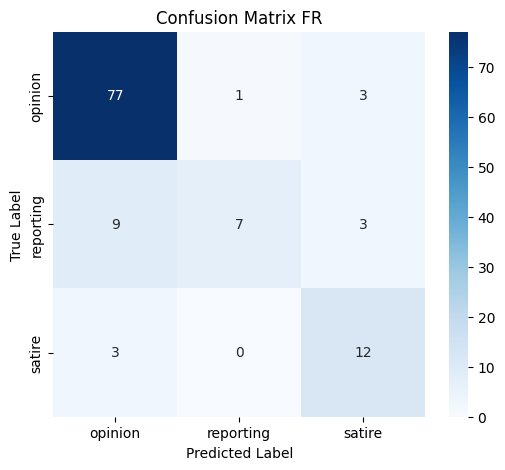

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.112697
2,No log,0.886188
3,No log,0.812883
4,No log,0.698502
5,No log,0.608448


Metrics - average = macro for DE
-------------------------
Precision: 0.7684
Recall: 0.7607
F1: 0.7257


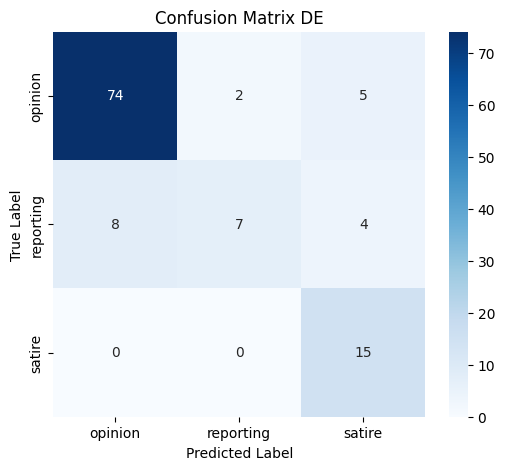

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.127882
2,No log,1.097311
3,No log,0.901494
4,No log,0.827924
5,No log,0.748754


Metrics - average = macro for ES
-------------------------
Precision: 0.7984
Recall: 0.6671
F1: 0.6510


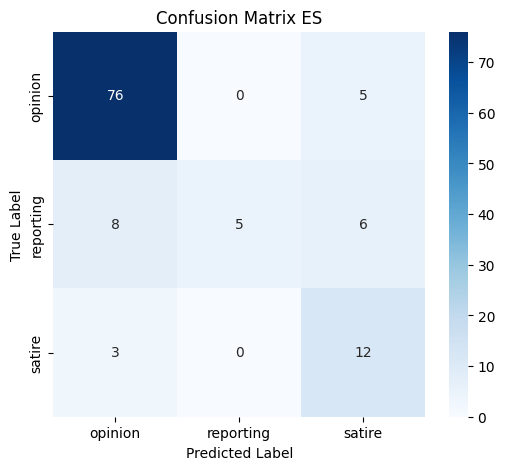

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.088755
2,No log,0.853209
3,No log,0.640329
4,No log,0.532835
5,No log,0.456063


Metrics - average = macro for PL
-------------------------
Precision: 0.8175
Recall: 0.8174
F1: 0.8135


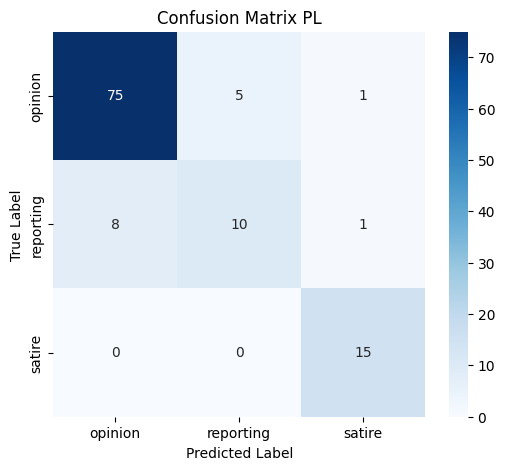

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,1.116403
2,No log,0.923038
3,No log,0.780590
4,No log,0.710761
5,No log,0.636339


Metrics - average = macro for RU
-------------------------
Precision: 0.8285
Recall: 0.7999
F1: 0.7820


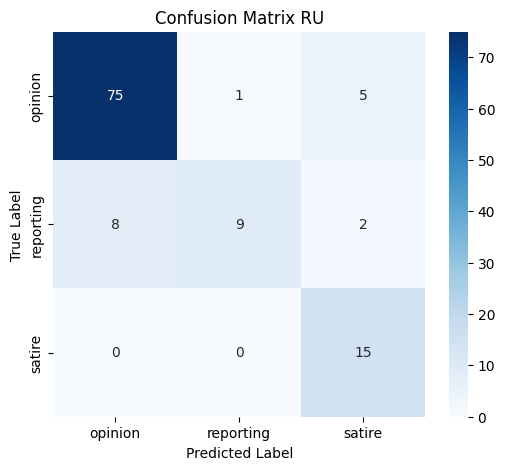

In [33]:
for articles_df, language in articles_all:
  # load the model each time
  model = XLMRobertaForSequenceClassification.from_pretrained(
      model_id,
      num_labels=len(id2label),
      problem_type="multi_label_classification",
  ).to(device)
  model.config.id2label = id2label
  model.config.label2id = label2id
  
  dataset = NewsGenreDataset(
      [article for article in articles_df["full_articles"].values],
      [label2id[genre] for genre in articles_df["genre"].values],
  )

  # split the dataset into train and validation
  train_idxs, validation_idxs = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.labels)
  train_dataset = torch.utils.data.Subset(dataset, train_idxs)
  validation_dataset = torch.utils.data.Subset(dataset, validation_idxs)

  # define training arguments
  training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=1e-4,
    eval_strategy="epoch",
  )

  # TRAINING
  # --------
  trainer = ClassWeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=tokenizer, 
  )
  trainer.train()

  # EVALUATION
  # ----------
  # compute the prediction logits
  val_predictions = trainer.predict(validation_dataset)
  # compute the prediction classes 
  val_predictions_labels = np.argmax(val_predictions.predictions, axis=1)
  # extract the true labels from the validation dataset
  val_true_labels = np.array([dataset[idx]["labels"] for idx in validation_dataset.indices])
  # compute metrics
  precision = precision_score(val_true_labels, val_predictions_labels, average="macro")
  recall = recall_score(val_true_labels, val_predictions_labels, average="macro")
  f1 = f1_score(val_true_labels, val_predictions_labels, average="macro")
  cm = confusion_matrix(val_true_labels, val_predictions_labels)

  print(f"Metrics - average = macro for {language.upper()}")
  print("-------------------------")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1: {f1:.4f}")

  plt.figure(figsize=(6,5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix {language.upper()}")
  plt.savefig(f"confusion_matrix_{language}.png", dpi=300, bbox_inches="tight")
  plt.show()
